In [ ]:
#| include: false
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy import linalg
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Introduction

**Singular Value Decomposition (SVD)** is a method from Linear Algebra that is used in a wide range of applications in science and engineering. It can be used for tasks such as dimensionality reduction, image compression, and even [understanding entanglement in quantum theory](https://www.math3ma.com/blog/understanding-entanglement-with-svd).

**Topic modeling** is an unsupervised machine learning technique used in Natural Language Processing (NLP) that’s capable of scanning a set of texts, detecting word and phrase patterns within them, and automatically clustering word groups and similar expressions that best characterize a set of documents.

In this article we will will use SVD to perform topic modelling.

This article is based in large part on the material from the [fastai linear algebra course](https://github.com/fastai/numerical-linear-algebra/blob/master/README.md).

## Dataset

We will use the [20 Newsgroups](https://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups) dataset which consists of 20,000 messages taken from 20 different newsgroups from the Usenet bulletin board service, which pre-dates the world-wide-web and websites. We will look at a subset of 4 of these newsgroup categories:

- rec.motorcycles
- talk.politics.mideast
- sci.med
- sci.crypt

We will now get this data.

In [ ]:

categories = ['rec.motorcycles', 'talk.politics.mideast', 'sci.med', 'sci.crypt']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

Let's check how many posts this gives us in total

In [ ]:

newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2351,), (2351,))

Let's print the first few lines of 3 of the posts to see what the text looks like

In [ ]:

print("\n".join(newsgroups_train.data[0].split("\n")[:3]))


I am not an expert in the cryptography science, but some basic things
seem evident to me, things which this Clinton Clipper do not address.


In [ ]:

print("\n".join(newsgroups_train.data[2].split("\n")[:3]))

Does the Bates method work?  I first heard about it in this newsgroup 
several years ago, and I have just got hold of a book, "How to improve your
sight - simple daily drills in relaxation", by Margaret D. Corbett, 


In [ ]:

print("\n".join(newsgroups_train.data[5].split("\n")[:3]))


Suggest McQuires #1 plastic polish.  It will help somewhat but nothing 
will remove deep scratches without making it worse than it already is.


We can also get the newsgroup category for each from the 'target_names' attribute

In [ ]:

np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['sci.crypt', 'sci.med', 'sci.med'], dtype='<U21')

To use this text dataset for topic modelling we will need to convert this into a **document-term** matrix. This is a matrix where the rows will correspond to to each of the newsgroup posts (a 'document' conceptually) and the columns will be for each of the words that exists in all posts (a 'term' conceptually). The values of the matrix will be the count of the number of words that exists for a particular post for each post/word combination in the matrix.

![](https://github.com/pranath/blog/raw/master/images/document-term-matrix.png "An example Document-Term matrix")

This method of converting text into a count of the words in the text matrix, without regard for anything else (such as order, context etc) is called a **bag of words** model. We can create this matrix using a *CountVectoriser()* function.

In [ ]:

vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape 

(2351, 32291)

We can see this matrix has the same number of rows as we have posts (2351) and we must have 32,291 unique words accross all posts which is the number of columns we have.

In [ ]:

print(len(newsgroups_train.data), vectors.shape)

2351 (2351, 32291)


If we print the matrix, its just an array of counts for each of the words in each post

In [ ]:

vectors

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 2, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

This matrix does not actually contain the names of the words, so it will be helpful for us to extract these as well to create a vocabulary of terms used in the matrix. We can extract these using *get_feature_names()*

In [ ]:

vocab = np.array(vectorizer.get_feature_names())
vocab.shape

(32291,)

In [ ]:

vocab[:32000]

array(['00', '000', '0000', ..., 'yarn', 'yarvin', 'yashir'], dtype='<U79')

While we have the newsgroup categories here, we will not actually use them for our topic modelling exercise, where we want to create topics independantly based on the posts alone, but we would hope these will correspond to the newsgroup categories in some way, indeed this would be a good check that the topic modelling is working.

Now we have our Document-Term matrix and the vocabulary, we are now ready to use Singular Value Decompostion.

## Singular Value Decomposition (SVD)

SVD is a method of matrix decomposition, so for a given matrix A we can convert it into 3 other matrices: U, $\sum_{}$, and $V^{T}$


![](https://github.com/pranath/blog/raw/master/images/svd.png "Singular Value Decompositon")

R is a value we choose in advance, in the case of our intention here R will repesent the number of topics we want to create for our topic model of the newsgroup posts.

Each of these matricies represents the following

- U: **Left singular vectors** this has the same number of rows as our original matrix A (m rows/posts) and a column for each of our chosen number of topics (r columns). This matrix has *orthogonal (or orthonormal) columns* i.e. vectors along the r topics column axis.
- $\sum_{}$: **Singular values** has r rows by r columns, in our case this means topics by topics. This represents the ranked relative importance of each topic so the most important topic is topic 1 which is in row 1, column 1 - and the value at this index will be a measure of the importance, and so on for topic 2 etc. This is a matrix of diagonal singular values (all other values off the diagonal are zero).
- $V^{T}$: **Right singular vectors** this has the same number of columns as our original matrix A (n columns) and a row for each of our chosen number of topics (r rows)

If we were to choose a R value equal to N this would be an **exact decompostion** of the matrix A, which would mean if we were to multiply U, $\sum_{}$, and $V^{T}$ we would get back exactly the same matrix A.

However there are many reasons why in practice we may not want to do a full decompostion, including in the case of large matricies this can be extermely time consuming, and often we may not require all potential topics, just the most important. So in practice we are likely to choose a value for R that is far smaller than N.

**Latent Semantic Analysis (LSA) or Latent Semantic Index (LSI)** is a common name given to applying SVD to topic modelling in NLP in this way i.e. using a Document-Term matrix.

Another way to think about SVD more generally is that whatever is represented by a matrix A by columns M and N, is mapped into a 'latent space' defined by the R dimension. Futhermore, this mapping is done in such a way that co-occuring values of N are projected into the same R dimensions with higher values, and conversley non-couccuring values on N are projected into different R dimensions. 

In other words, the latent space R dimensions allow us to show which M are similar or different based on their values of N.

So we can peform full SVD on our Document-Term matrix using the scipy *linalg* module.

In [ ]:

%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 1min 55s, sys: 5.34 s, total: 2min
Wall time: 1min 2s


In [ ]:

print(U.shape, s.shape, Vh.shape)

(2351, 2351) (2351,) (2351, 32291)


This has performed a full SVD, and took around 2 mins. 

We can test that this is a decomposition by multipling these matrices and checking if they are close to equal to the original matrix using the *allclose()* function from numpy.

In [ ]:

# Confirm that U, s, Vh is a decomposition of the var Vectors
# Multiply matrices
reconstructed_vectors = U @ np.diag(s) @ Vh
# Calculate the Frobenius norm between the original matrix A and this reconstructed one - which is a measure of the distance/differences between these matrices
np.linalg.norm(reconstructed_vectors - vectors)

4.063801905115974e-12

In [ ]:

# Check if two matrices are approximately equal within a small difference
np.allclose(reconstructed_vectors, vectors)

True

We can also check that U and Vh are orthonormal matrices. [If we multiply these by their transpose this should be close to equal to the identity matrix for each of these (by definition).](https://en.wikipedia.org/wiki/Orthogonal_matrix).

In [ ]:

# Confirm that U, Vh are orthonormal
np.allclose(U.T @ U, np.eye(U.shape[0]))
np.allclose(Vh @ Vh.T, np.eye(Vh.shape[0]))

True

If we look at the singular values matrix, we can get an idea of the relative importance of each of the topics (topics on x axis)

Text(0, 0.5, 'Importance')

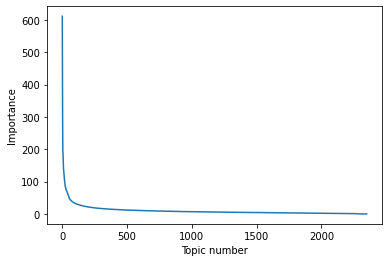

In [ ]:

plt.plot(s)
plt.xlabel('Topic number')
plt.ylabel('Importance')

Let's have a look at the topics discovered by SVD, we will do this by looking at the top 8 words that score most highly for each topic. This will be orderded by most important topic first.

In [ ]:

num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

print('Top 10 topics, described by top words in each topic')
show_topics(Vh[:10])

Top 10 topics, described by top words in each topic


['melittin wimp disgruntled rebelling toxin sorta bikeless litte',
 'db mov bh si bl di maxbyte cx',
 'said didn people know don went apartment came',
 'health 1993 hiv medical use 10 number 20',
 'edu com anonymous health posting anon service cs',
 'key privacy eff pub encryption use law health',
 'internet email privacy anonymous anonymity health eff hiv',
 'anonymous posting anonymity use anon key users postings',
 'com edu encryption privacy government said chip technology',
 'version machines contact type pc comments ftp keyboard']

So if you recall our original news group categories were:

- rec.motorcycles
- talk.politics.mideast
- sci.med
- sci.crypt

We can see that the topics discovered correspond fairly well to these, bar a few anomalies.

## Truncated SVD

So we saw from our attempt at full SVD was quite slow to calculate (approx 2 mins) we can imagine this is likely to get far worse with bigger matrices. We also know that perhaps we don't need to calculate a full set of topics, especially given for most practical applications we are most likely interested in using the strongest topics that distinguish posts, rather than topics that are not very useful. The approaches to calculate full SVD use particular algorithms to create the decomposition, and [Halko et al](https://arxiv.org/abs/0909.4061) highlighted some of the key disadvantages of this approach:

-  Matrices are "stupendously big"
- Data are often missing or inaccurate. Why spend extra computational resources when imprecision of input limits precision of the output?
- Data transfer now plays a major role in time of algorithms. Techniques the require fewer passes over the data may be substantially faster, even if they require more flops (flops = floating point operations).
- Important to take advantage of GPUs.

In the same paper, Halko et al argued for the advantages of using randomised approaches which include:

- They are inherently stable
- Performance guarantees do not depend on subtle spectral properties
- Needed matrix-vector products can be done in parallel i.e. on a GPU

So **Truncated SVD** using a randomised approach, allows us to calculate just the largest singular values and the corresponding matrices, which should be much quicker to calculate.

We can use sklearn's *decomposition* module to calculated randomised SVD, we will specify the top 10 topics only.

In [ ]:

%time u, s, v = decomposition.randomized_svd(vectors, 10)

CPU times: user 18.7 s, sys: 2.09 s, total: 20.8 s
Wall time: 15.2 s


Lets see the top 10 topics its discovered.

In [ ]:

show_topics(v)

['db mov bh si cs byte al bl',
 'people said know don didn anonymous privacy internet',
 'privacy internet anonymous information pub email eff use',
 'health 1993 hiv medical use 10 number 20',
 'turkish jews turkey key privacy government armenian eff',
 'turkish edu jews com turkey anonymous jewish nazis',
 'key edu encryption des com ripem chip keys',
 'com edu pub eff ftp electronic org computer',
 'dod rec denizens motorcycle motorcycles doom ftp terrible',
 'version machines contact type pc comments ftp keyboard']

So this is much faster taking a total of 20 seconds for randomised SVD compared to the full SVD of 2 minutes.

[Facebook Research implemented a version of Randomised SVD](https://research.facebook.com/blog/2014/09/fast-randomized-svd/) based on the Halko paper.



## Conclusion

In this article we introduced Singular Value Decomposition (SVD) and saw how it could be applied to the task of topic modelling in NLP. We also saw how this could be optimised for speed when only concerned with the most important topics, using truncated SVD implemented using a randomised approach.